**TRABAJO PRÁCTICO 1 NLP - PARTE 2**

*Integrante:* Lucía Masciángelo


# Ejercicio 2

Apoyándose en la sección de información. Separa en fragmentos un texto extenso extraído
y vectoriza cada fragmento con alguno de los modelos de embedding vistos en clases.

Luego realiza un análisis de similitud de texto ingresando varias frases a buscar
semánticamente, compare distintas técnicas de distancias vistas en clases, elija la mejor y
justifique la razón por la que esa técnica se ajusta para este tipo de búsquedas.

*OPCIONAL:* Visualizar en 3D aplicando PCA o t-SNE la ubicación de los fragmentos y la
query ingresada vectorizada en el espacio. Realizar una observación sobre la visualización.

### Montar Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Ruta donde se encuentra información
cascadia_path = "/content/drive/MyDrive/NLP_CASCADIA_AD/datos/información"

# Verificar si la carpeta existe
os.path.exists(cascadia_path)

True

### Vemos cual es el archivo más largo para trabajar sobre ese mismo

Recorre cada uno de los archivos de la carpeta información y calcula la cantidad de carácteres

In [ ]:
# Diccionario para almacenar los resultados
longitudes = {}

# Recorremos cada archivo
for archivo in os.listdir(cascadia_path):
    ruta_archivo = os.path.join(cascadia_path, archivo)

    # Verificamos que sea archivo y de texto
    if os.path.isfile(ruta_archivo) and archivo.endswith(".txt"):
        try:
            with open(ruta_archivo, 'r', encoding='utf-8') as f:
                contenido = f.read()
                longitudes[archivo] = len(contenido)
        except Exception as e:
            longitudes[archivo] = f"Error al leer: {str(e)}"

# Ordena los archivos por longitud en orden descendente
longitudes_ordenadas = dict(sorted(longitudes.items(), key=lambda x: isinstance(x[1], int) and -x[1] or 0))

# Mostrar los resultados ordenados por cantidad de caracteres (descendente)
for archivo, longitud in longitudes_ordenadas.items():
    print(f"{archivo}: {longitud} caracteres")

cascadia_manual.txt: 39301 caracteres
boardgamereview_review.txt: 17695 caracteres
whatboardgame_review.txt: 13071 caracteres
oneboardfamily_review.txt: 10430 caracteres
bluehighwaygames_description.txt: 9276 caracteres
flatout_games.txt: 2499 caracteres
board_game_co_uk_guide.txt: 909 caracteres


Vemos que el archivo más largo de los que se encuentran en la carpeta información es 'cascadia_manual.txt' así que trabajaremos sobre ese para realizar el ejercicio.

### Segmentación de texto

Utilizamos spacy para dividir el texto en oraciones, utilizando 4 oraciones por chunk con un overlap de 1 oración para poder conservar el contexto entre chunks

In [3]:
import spacy

cascadia_manual_text = open('/content/drive/MyDrive/NLP_CASCADIA_AD/datos/información/cascadia_manual.txt', 'r', encoding='utf-8').read()

# Cargar modelo de spaCy (inglés)
nlp = spacy.load("en_core_web_sm")

# Procesar el texto
doc = nlp(cascadia_manual_text)

# Extraer oraciones como strings
oraciones = [sent.text.strip() for sent in doc.sents if sent.text.strip()]

# Definir tamaño del chunk y solapamiento
tam_chunk = 4
overlap = 1

# Crear chunks con solapamiento
chunks = []
for i in range(0, len(oraciones), tam_chunk - overlap):
    chunk = " ".join(oraciones[i:i + tam_chunk])
    chunks.append(chunk)

# Mostrar los primeros 3 fragmentos
for i, chunk in enumerate(chunks[:3]):
    print(f"\n--- Fragmento {i+1} ---\n{chunk}")


--- Fragmento 1 ---
C A S C A D I A™

RULEBOOK

3

RANDY FLYNN™

A puzzly tile-laying and token-drafting game featuring the habitats & wildlife 
of the Pacific Northwest. Designed by Randy Flynn, for 1-4 players, ages 10+. About the Region
The Pacific Northwest, also referred to as Cascadia (kas-KAE-Dee-uh), is a geographic region in 
western North America bounded by the Pacific Ocean to the west and (loosely) by the Rocky 
Mountains to the east. Though no official boundary exists, the most common conception 
includes the Canadian province of British Columbia and Yukon Territory as well as the U.S. 
states of Idaho, Oregon, and Washington.

--- Fragmento 2 ---
Though no official boundary exists, the most common conception 
includes the Canadian province of British Columbia and Yukon Territory as well as the U.S. 
states of Idaho, Oregon, and Washington. About the Game

In Cascadia™, players compete to create the most diverse Pacific Northwest 
environment as they draft Habitat Tiles 

### Vectorizar por segmento (palabra)

In [ ]:
# Instalar transformers
!pip install transformers

Utilizamos como vectorizador BERT (Token CLS), un modelo que funciona muy bien para vectorizar el texto por segmentos

In [4]:
import torch
from transformers import BertTokenizer, BertModel

# Cargar modelo BERT multilingüe
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

# Vectorizar los chunks usando el embedding del token CLS
embeddings_bert = []
for chunk in chunks:
    inputs = tokenizer(chunk, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[0, 0]
        embeddings_bert.append(cls_embedding)

print(f"{len(embeddings_bert)} fragmentos vectorizados.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


116 fragmentos vectorizados.


### Vectorizar por oración

In [ ]:
# Instalar Sentence Transformers
!pip install -U sentence-transformers

Se eligió utilizar vectorización a nivel de oraciones mediante un modelo del tipo Sentence-BERT,
dado que este tipo de modelos están específicamente diseñados para capturar la similitud semántica entre textos completos,
lo cual se ajusta al objetivo del trabajo práctico: comparar fragmentos del manual con frases de consulta.
La alternativa de vectorizar palabras y luego combinarlas es menos eficaz y más costosa computacionalmente,
especialmente cuando ya se dispone de embeddings entrenados para oraciones completas.


In [ ]:
from sentence_transformers import SentenceTransformer

modelo_sbert = SentenceTransformer('all-MiniLM-L6-v2')
embeddings_sbert = modelo_sbert.encode(chunks, convert_to_tensor=True)

### Comparación de métricas

In [27]:
# Definimos las queries para la comparación

queries = [
    "The wildlife scoring system awards points based on specific patterns formed by animals.",
    "Tile placement must follow adjacency rules according to terrain type and token compatibility.",
    "The game progresses over a fixed number of turns during which players take specific actions.",
    "Players are not allowed to exchange tiles or tokens during the game under normal rules.",
    "Final points are tallied by summing terrain bonuses and wildlife scoring objectives."
]

Definimos las funciones para medir las distancias

In [ ]:
!pip install -q python-Levenshtein jellyfish scikit-learn pandas

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
import Levenshtein
import jellyfish
import numpy as np

def jaccard_set(a, b):
    sa, sb = set(a.lower().split()), set(b.lower().split())
    return len(sa & sb) / len(sa | sb)

def dice(a, b):
    sa, sb = set(a.lower().split()), set(b.lower().split())
    return 2 * len(sa & sb) / (len(sa) + len(sb))

def levenshtein_dist(a, b):
    return Levenshtein.distance(a.lower(), b.lower())

def jaro_winkler(a, b):
    return jellyfish.jaro_winkler_similarity(a.lower(), b.lower())

def tfidf_cosine(a, b):
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform([a, b])
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])[0][0]

In [32]:
# Función de comparación para un modelo
def comparar_modelo(nombre_modelo, embeddings, vector_fn, queries, chunks):
    resultados = []

    for query in queries:
        if nombre_modelo == "BERT":
            inputs = vector_fn(query)
            with torch.no_grad():
                outputs = model(**inputs)
                q_vec = outputs.last_hidden_state[0, 0]
                sims = cosine_similarity([q_vec.numpy()], torch.stack(embeddings).numpy())[0]
        else:
            q_vec = vector_fn(query, convert_to_tensor=True)
            sims = cosine_similarity([q_vec.cpu().numpy()], embeddings.cpu().numpy())[0]

        top_idx = sims.argmax()
        top_text = chunks[top_idx]

        resultados.append({
            "Query": query,
            "Fragmento más similar": top_text,
            "Coseno (TF-IDF)": tfidf_cosine(query, top_text),
            "Jaccard (sets)": jaccard_set(query, top_text),
            "Dice": dice(query, top_text),
            "Levenshtein": levenshtein_dist(query, top_text),
            "Jaro-Winkler": jaro_winkler(query, top_text)
        })

    return pd.DataFrame(resultados)

In [33]:
# Función de vectorización para BERT
bert_vector_fn = lambda x: tokenizer(x, return_tensors='pt', truncation=True, max_length=512)

# Comparar
df_bert = comparar_modelo("BERT", embeddings_bert, bert_vector_fn, queries, chunks)
df_sbert = comparar_modelo("S-BERT", embeddings_sbert, modelo_sbert.encode, queries, chunks)

# Mostrar
import pandas as pd
display(df_bert)
display(df_sbert)

,Query,Fragmento más similar,Coseno (TF-IDF),Jaccard (sets),Dice,Levenshtein,Jaro-Winkler
0,The wildlife scoring system awards points base...,"Whenever you fill in a shape, fill in the next...",0.106652,0.046154,0.088235,398,0.579876
1,Tile placement must follow adjacency rules acc...,Tiles are included in a contiguous habitat cor...,0.059540,0.055556,0.105263,492,0.555024
2,The game progresses over a fixed number of tur...,Scenarios can be played in multi-player or sol...,0.070639,0.044776,0.085714,334,0.582945
3,Players are not allowed to exchange tiles or t...,10\n\n \n WILDLIFE SCORING CARDS\n\nA\n\nC\n\n...,0.080014,0.060606,0.114286,409,0.557346
4,Final points are tallied by summing terrain bo...,10\n\n \n WILDLIFE SCORING CARDS\n\nA\n\nC\n\n...,0.050144,0.030769,0.059701,408,0.551471


,Query,Fragmento más similar,Coseno (TF-IDF),Jaccard (sets),Dice,Levenshtein,Jaro-Winkler
0,The wildlife scoring system awards points base...,End Game & Scoring: Follow scoring on pages 8-...,0.215013,0.076923,0.142857,232,0.603113
1,Tile placement must follow adjacency rules acc...,If you do not have any \nremaining Nature Toke...,0.249619,0.104478,0.189189,601,0.548628
2,The game progresses over a fixed number of tur...,The game ends when there are no more Habitat T...,0.159098,0.085366,0.157303,596,0.555673
3,Players are not allowed to exchange tiles or t...,Note: when replacing tiles and tokens in the p...,0.220242,0.128205,0.227273,145,0.628344
4,Final points are tallied by summing terrain bo...,End Game & Scoring: Follow scoring on pages 8-...,0.111849,0.037736,0.072727,232,0.588899


Tras comparar el desempeño de BERT y S-BERT en una tarea de recuperación semántica de texto, se observa que S-BERT supera sistemáticamente a BERT en todas las métricas evaluadas, incluyendo similitud coseno (TF-IDF), Jaccard, Dice, Levenshtein y Jaro-Winkler. Esto sugiere que S-BERT no solo comprende mejor el significado subyacente de los fragmentos consultados, sino que también tiende a seleccionar textos más alineados en vocabulario y estructura.

Por tanto, S-BERT se posiciona como el modelo más adecuado para tareas de búsqueda semántica sobre fragmentos textuales, en particular dentro del contexto del juego Cascadia y documentos con estructuras similares.

Ahora bien, si focalizamos exclusivamente en los resultados obtenidos por S-BERT, se destaca que la métrica Jaro-Winkler presenta valores consistentemente superiores respecto al resto de las mediciones. Esto indica que los fragmentos recuperados no solo coinciden semánticamente, sino que también comparten similitudes importantes en la estructura y orden de las frases, ya que esta métrica pondera especialmente los prefijos comunes entre cadenas.

### Gráficos

In [ ]:
# Instalar librerías
!pip install sentence-transformers matplotlib scikit-learn

#### T-sne

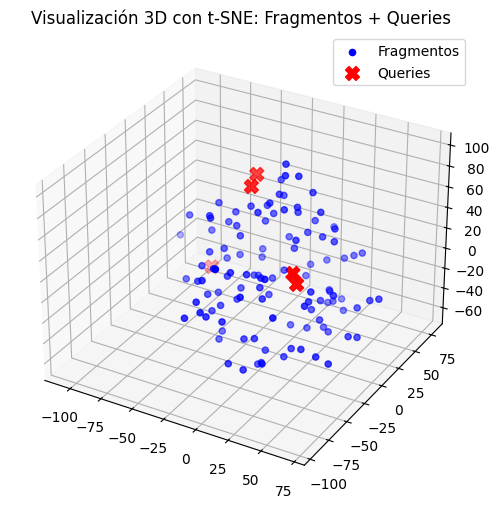

In [34]:
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Modelo sBERT
modelo = SentenceTransformer('all-MiniLM-L6-v2')

# Vectorización
embeddings_chunks = modelo.encode(chunks)
embeddings_queries = modelo.encode(queries)
embeddings_all = np.vstack([embeddings_chunks, embeddings_queries])

# Reducción de dimensionalidad
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings_all)

# Coordenadas
coords_chunks = embeddings_3d[:len(chunks)]
coords_queries = embeddings_3d[len(chunks):]

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(coords_chunks[:, 0], coords_chunks[:, 1], coords_chunks[:, 2], c='blue', label='Fragmentos')
ax.scatter(coords_queries[:, 0], coords_queries[:, 1], coords_queries[:, 2], c='red', s=100, marker='X', label='Queries')

ax.set_title('Visualización 3D con t-SNE: Fragmentos + Queries')
ax.legend()
plt.show()

En la visualización tridimensional generada mediante t-SNE se observa que las queries (en rojo) tienden a ubicarse cerca de los fragmentos azules, lo que indica que el modelo S-BERT logró representarlas en una región semánticamente coherente dentro del espacio vectorial.

Dado que t-SNE preserva la estructura de vecindades locales, este resultado sugiere que las queries están correctamente alineadas con fragmentos relevantes según su significado, reforzando que S-BERT es un modelo eficaz para esta tarea de búsqueda semántica.

#### PCA

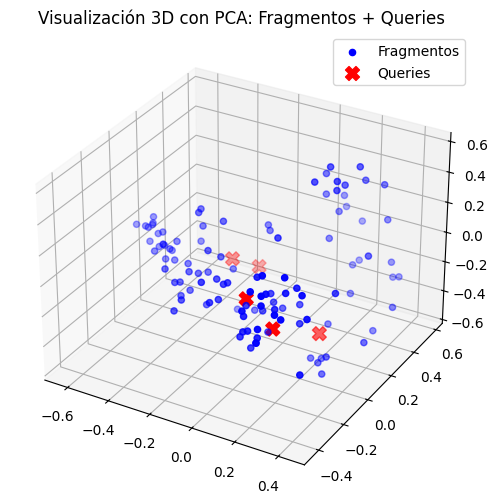

In [35]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings_all)

# Coordenadas
coords_chunks = embeddings_3d[:len(chunks)]
coords_queries = embeddings_3d[len(chunks):]

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(coords_chunks[:, 0], coords_chunks[:, 1], coords_chunks[:, 2], c='blue', label='Fragmentos')
ax.scatter(coords_queries[:, 0], coords_queries[:, 1], coords_queries[:, 2], c='red', s=100, marker='X', label='Queries')

ax.set_title('Visualización 3D con PCA: Fragmentos + Queries')
ax.legend()
plt.show()

La proyección mediante PCA también muestra que las queries (en rojo) se encuentran agrupadas dentro de una región densa del espacio de los fragmentos. Si bien PCA no preserva relaciones no lineales como t-SNE, en este caso permite visualizar que las queries comparten componentes principales con los fragmentos relevantes, lo que indica que tienen una representación distribuida coherente.

Esto complementa la observación anterior y valida que S-BERT genera embeddings compatibles en el espacio semántico, incluso bajo una proyección lineal como la de PCA.

# Ejercicio 3

Apoyándose nuevamente en la sección de información. Recoge un texto extenso extraído,
divídelos en fragmentos, luego realiza extracciones de sustantivos (POS) y categoriza estos
sustantivos (NER), a continuación realiza una búsqueda de similitud filtrando por
sustantivos, compara las distintas técnicas de distancias vistas en clases, elija la mejor y
justifique la razón por la que esta técnica se ajusta para este tipo de búsquedas.


En este caso vamos a utilizar el segundo texto más largo: 'boardgamereview_review.txt'

In [1]:
# Instalar spaCy y modelo en inglés si no está instalado
!pip install -U spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import spacy
import pandas as pd

# Cargar modelo de spaCy en inglés
nlp = spacy.load('en_core_web_sm')

# Leer el texto desde tu Google Drive
ruta_archivo = '/content/drive/MyDrive/NLP_CASCADIA_AD/datos/información/boardgamereview_review.txt'

with open(ruta_archivo, encoding='utf-8') as f:
    texto = f.read()

# Procesar el texto
doc = nlp(texto)

# Crear lista con token, POS y explicación
data = []
for token in doc:
    data.append([token.text, token.pos_, spacy.explain(token.pos_)])

# Convertir a DataFrame
df = pd.DataFrame(data, columns=['Token', 'POS', 'Explicación'])

In [3]:
df

,Token,POS,Explicación
0,\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n,SPACE,space
1,Cascadia,PROPN,proper noun
2,Review,PROPN,proper noun
3,-,PUNCT,punctuation
4,Board,PROPN,proper noun
...,...,...,...
3437,\n\t\t\t\t\t\t\t\t\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,SPACE,space
3438,SAVE,PROPN,proper noun
3439,&,CCONJ,coordinating conjunction
3440,ACCEPT,PROPN,proper noun


Podemos observar que el texto está muy sucio, tiene demasiados espacios y texto extraído de la página, pero que no es relevante en la reseña en sí, y no me permite hacer una buena interpretación de la información por lo que voy a proceder a limpiarlo.

### Limpieza de texto

In [4]:
import re

# Ruta del archivo
ruta = '/content/drive/MyDrive/NLP_CASCADIA_AD/datos/información/boardgamereview_review.txt'

# Leer el texto completo
with open(ruta, encoding='utf-8') as f:
    texto = f.read()

# 1. Recortar desde el título hasta el final de la reseña (dado que nos diste el final)
inicio = "Cascadia Review - Board Game Review"
fin = "The puzzle and gameplay is just so darn enjoyable!"

# Buscar los índices
start_idx = texto.find(inicio)
end_idx = texto.find(fin) + len(fin)

# Recortar el texto útil
texto_util = texto[start_idx:end_idx]

# 2. Eliminar la lista de etiquetas interrumpidas (coma en líneas separadas)
# Usamos una expresión regular que detecta ", \nPalabra\n" repetido
texto_util = re.sub(r'(,\s*\n\s*(Board Games|Family Games|Flatout Games|Randy Flynn|Tile-laying Games)\s*)+', '', texto_util, flags=re.IGNORECASE)

# 3. Limpiar espacios innecesarios
texto_util = re.sub(r'\n{2,}', '\n', texto_util)  # quitar saltos múltiples
texto_util = re.sub(r'\s{2,}', ' ', texto_util)   # quitar espacios múltiples

In [5]:
# Mostrar el texto limpio
print(texto_util)

Cascadia Review - Board Game Review Skip to content
Menu
Board Game Review Search
Home Reviews Features Days Out Videos About Close Menu 24 12 2024 Cascadia Review
AEG (Alderac Entertainment Group)
The great outdoors is the inspiration for many board games. With nature clearly being a fan favourite, perhaps others like me, prefer the great indoors and to live vicariously through their board games! Cascadia is one of only a few nature-themed games that has secured its place on the Board Game Geek Top 100. If you’re wondering why, you’ve come to the right place. Get comfy and we will crack on with the review… ©boardgamereview.co.uk TLDR: click for final thoughts and scores Setup
First thing to do is remove habitat tiles according to the Setup in the rulebook depending on player count. Choose a set of Wildlife Scoring Cards and lay them out for all to see. Then, give each player a random starting board and decide on the first player. Place stacks of the remaining habitat tiles face down, 

Una vez que tenemos el texto limpio, manteniendo únicamente lo necesario para der realizar el ejercicio, vamos a dividirlo en oraciones para luego poder hacer una extracción dsustantivos por oraciones

### Segmentación por oraciones

In [6]:
!pip install pysbd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 3.9 MB/s eta 0:00:00


In [7]:
import pysbd

# Inicializamos el segmentador de oraciones para inglés
seg = pysbd.Segmenter(language="en", clean=False)

# Definimos el texto limpio
texto = texto_util

# Usamos pySBD para segmentar el texto en oraciones individuales
oraciones = seg.segment(texto)

# Imprimimos las oraciones individuales
for i, oracion in enumerate(oraciones):
    print(f"Oración {i+1}: {oracion}")

Oración 1: Cascadia Review - Board Game Review Skip to content

Oración 2: Menu

Oración 3: Board Game Review Search

Oración 4: Home Reviews Features Days Out Videos About Close Menu 24 12 2024 Cascadia Review

Oración 5: AEG (Alderac Entertainment Group)

Oración 6: The great outdoors is the inspiration for many board games. 
Oración 7: With nature clearly being a fan favourite, perhaps others like me, prefer the great indoors and to live vicariously through their board games! 
Oración 8: Cascadia is one of only a few nature-themed games that has secured its place on the Board Game Geek Top 100. 
Oración 9: If you’re wondering why, you’ve come to the right place. 
Oración 10: Get comfy and we will crack on with the review… ©boardgamereview.co.uk TLDR: click for final thoughts and scores Setup

Oración 11: First thing to do is remove habitat tiles according to the Setup in the rulebook depending on player count. 
Oración 12: Choose a set of Wildlife Scoring Cards and lay them out for 

### POS

Procesamos cada oración y aplicamos POS, para que nos devuelva qué tipo de palabra es cada una de las palabras del texto

In [8]:
import spacy
import pandas as pd

# Cargar el modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

# Lista para guardar resultados
datos_pos = []

# Recorremos cada oración y aplicamos spaCy
for i, oracion in enumerate(oraciones):
    doc = nlp(oracion)
    for token in doc:
        datos_pos.append({
            "Oración N°": i+1,
            "Token": token.text,
            "POS": token.pos_,
            "Explicación POS": spacy.explain(token.pos_)
        })

# Crear DataFrame con los resultados
df_pos = pd.DataFrame(datos_pos)

In [9]:
df_pos

,Oración N°,Token,POS,Explicación POS
0,1,Cascadia,PROPN,proper noun
1,1,Review,PROPN,proper noun
2,1,-,PUNCT,punctuation
3,1,Board,PROPN,proper noun
4,1,Game,PROPN,proper noun
...,...,...,...,...
1600,87,just,ADV,adverb
1601,87,so,ADV,adverb
1602,87,darn,ADV,adverb
1603,87,enjoyable,ADJ,adjective


### NER

Filtramos el df para extraer sólo los sustantivos (NOUN y PROPN) y lueo aplicamos NER

In [10]:
# Filtrar solo sustantivos comunes y propios
df_sustantivos = df_pos[df_pos["POS"].isin(["NOUN", "PROPN"])].copy()

**Detectar entidades con NER por oración y mapearlas a los tokens**

Vamos a:

- Reprocesar cada oración con nlp (ya que NER se basa en doc.ents)

- Asociar cada sustantivo con la entidad en la que aparece (si aplica)

In [11]:
# Lista para resultados finales
datos_ner = []

# Recorremos las oraciones originales otra vez
for i, oracion in enumerate(oraciones):
    doc = nlp(oracion)

    # Crear un set de tokens que pertenecen a entidades nombradas
    entidades = {ent.text: ent.label_ for ent in doc.ents}

    # Asociar entidad a cada sustantivo de esa oración
    for token in doc:
        if token.pos_ in ["NOUN", "PROPN"]:
            entidad = None
            for ent in doc.ents:
                if token.idx >= ent.start_char and token.idx < ent.end_char:
                    entidad = ent.label_
                    break

            datos_ner.append({
                "Oración N°": i+1,
                "Token": token.text,
                "POS": token.pos_,
                "Entidad NER": entidad if entidad else "—"
            })

# Crear nuevo DataFrame con sustantivos y NER
df_sustantivos_ner = pd.DataFrame(datos_ner)

In [12]:
df_sustantivos_ner

,Oración N°,Token,POS,Entidad NER
0,1,Cascadia,PROPN,ORG
1,1,Review,PROPN,ORG
2,1,Board,PROPN,ORG
3,1,Game,PROPN,ORG
4,1,Review,PROPN,ORG
...,...,...,...,...
352,86,Cascadia,PROPN,ORG
353,86,game,NOUN,—
354,86,table,NOUN,—
355,87,puzzle,NOUN,—


En el df anterior mdevuelve cada palabra por separado, incluso cuaando algunas corresponden a una sola frase (frase sustantiva), así que vamos a juntar esas frases que corresponden a la misma entidad para que sea más entendible

In [13]:
# Lista para guardar resultados de entidades
entidades_extraidas = []

# Recorremos cada oración y sus entidades
for i, oracion in enumerate(oraciones):
    doc = nlp(oracion)

    for ent in doc.ents:
        # Verificamos si todos los tokens en la entidad son NOUN o PROPN
        if all(token.pos_ in ['NOUN', 'PROPN'] for token in ent):
            entidades_extraidas.append({
                "Oración N°": i+1,
                "Entidad completa": ent.text,
                "Etiqueta NER": ent.label_,
                "Tokens": [token.text for token in ent],
                "POS tags": [token.pos_ for token in ent]
            })

# Convertir a DataFrame
df_entidades = pd.DataFrame(entidades_extraidas)

In [14]:
df_entidades

,Oración N°,Entidad completa,Etiqueta NER,Tokens,POS tags
0,3,Board Game Review Search,ORG,"[Board, Game, Review, Search]","[PROPN, PROPN, PROPN, PROPN]"
1,4,Cascadia Review,ORG,"[Cascadia, Review]","[PROPN, PROPN]"
2,5,AEG,ORG,[AEG],[PROPN]
3,5,Alderac Entertainment Group,ORG,"[Alderac, Entertainment, Group]","[PROPN, PROPN, PROPN]"
4,8,Cascadia,ORG,[Cascadia],[PROPN]
5,11,Setup,PERSON,[Setup],[PROPN]
6,12,Wildlife Scoring Cards,ORG,"[Wildlife, Scoring, Cards]","[PROPN, PROPN, PROPN]"
7,35,Cascadia,GPE,[Cascadia],[PROPN]
8,45,fox,ORG,[fox],[NOUN]
9,50,Cascadia,GPE,[Cascadia],[PROPN]


In [15]:
# Aplanar la lista de todos los tokens dentro de la columna "Tokens"
sustantivos_extraidos = set(token for sublist in df_entidades["Tokens"] for token in sublist)

# Convertir a lista ordenada
sustantivos_extraidos = sorted(list(sustantivos_extraidos))

# Mostrar ejemplo
print(sustantivos_extraidos)

['AEG', 'Age', 'Alderac', 'Board', 'Cards', 'Cascadia', 'Entertainment', 'Etsy', 'Facts', 'Final', 'Flynn', 'Game', 'Group', 'Key', 'RRP', 'Randy', 'Recommended', 'Review', 'Scoring', 'Search', 'Setup', 'Wildlife', 'boardgamereview.co.uk', 'fox']


### Comparación entre distancias

A continuación vamos a elegir dos palabras: "Cascadie" y "Cascadis" para medir cómo funcionan las distintas distancias con respecto a palabras que está "mal escrita"

In [16]:
!pip install -q scikit-learn python-Levenshtein jellyfish

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
import Levenshtein
import jellyfish
import pandas as pd

# Sustantivos del análisis real
sustantivos = sustantivos_extraidos

def comparar_todas(query, lista):
    resultados = []

    for word in lista:
        # Coseno con TF-IDF
        tfidf = TfidfVectorizer().fit([query, word])
        vecs = tfidf.transform([query, word])
        cos = cosine_similarity(vecs[0:1], vecs[1:2])[0][0]

        # Jaccard (sets de letras)
        set_a = set(query)
        set_b = set(word)
        jaccard = len(set_a & set_b) / len(set_a | set_b)

        # Dice
        dice = 2 * len(set_a & set_b) / (len(set_a) + len(set_b))

        # Levenshtein
        lev = Levenshtein.distance(query, word)

        # Jaro-Winkler
        jaro = jellyfish.jaro_winkler_similarity(query, word)

        resultados.append({
            "Sustantivo": word,
            "Similitud Coseno": round(cos, 4),
            "Jaccard": round(jaccard, 4),
            "Dice": round(dice, 4),
            "Levenshtein": lev,
            "Jaro-Winkler": round(jaro, 4)
        })

    return pd.DataFrame(resultados).sort_values(by="Similitud Coseno", ascending=False)

# Ejecutar
# HACER COMPARACIÓN CON DOS PALABRAS MAL ESCRITAS
df_cascadie = comparar_todas("Cascadie", sustantivos)
df_cascadis = comparar_todas("Cascadis", sustantivos)

In [21]:
df_cascadie

,Sustantivo,Similitud Coseno,Jaccard,Dice,Levenshtein,Jaro-Winkler
0,AEG,0.0,0.0000,0.0000,8,0.0000
1,Age,0.0,0.1111,0.2000,7,0.0000
2,Alderac,0.0,0.4000,0.5714,8,0.4901
3,Board,0.0,0.2000,0.3333,7,0.5500
4,Cards,0.0,0.5000,0.6667,5,0.6833
5,Cascadia,0.0,0.8571,0.9231,1,0.9500
6,Entertainment,0.0,0.2500,0.4000,11,0.4241
7,Etsy,0.0,0.1000,0.1818,7,0.4583
8,Facts,0.0,0.3333,0.5000,6,0.5472
9,Final,0.0,0.2000,0.3333,7,0.4417


In [22]:
df_cascadis

,Sustantivo,Similitud Coseno,Jaccard,Dice,Levenshtein,Jaro-Winkler
0,AEG,0.0,0.0000,0.0000,8,0.0000
1,Age,0.0,0.0000,0.0000,8,0.0000
2,Alderac,0.0,0.3000,0.4615,8,0.4901
3,Board,0.0,0.2222,0.3636,7,0.5500
4,Cards,0.0,0.5714,0.7273,4,0.6833
5,Cascadia,0.0,1.0000,1.0000,1,0.9500
6,Entertainment,0.0,0.1667,0.2857,12,0.4679
7,Etsy,0.0,0.1111,0.2000,7,0.4583
8,Facts,0.0,0.3750,0.5455,5,0.5472
9,Final,0.0,0.2222,0.3636,7,0.4417


### Gráfico comparativo

In [28]:
def obtener_top_similares(df_comparacion, top_n=5):
    """
    Calcula el promedio de similitud sin incluir Levenshtein (que es distancia),
    ordena y devuelve el top_n resultados.
    """
    df = df_comparacion.copy()
    df["Promedio (sin Levenshtein)"] = df[[
        "Similitud Coseno", "Jaccard", "Dice", "Jaro-Winkler"
    ]].mean(axis=1)
    return df.sort_values(by="Promedio (sin Levenshtein)", ascending=False).head(top_n)

top_cascadie = obtener_top_similares(df_cascadie)
top_cascadis = obtener_top_similares(df_cascadis)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# FUNCIÓN PARA GRAFICAR
def graficar_comparacion(df, titulo):
    plt.figure(figsize=(10, 6))
    bar_width = 0.15
    x = np.arange(len(df))

    plt.bar(x - 2*bar_width, df["Similitud Coseno"], width=bar_width, label='Coseno')
    plt.bar(x - bar_width, df["Jaccard"], width=bar_width, label='Jaccard')
    plt.bar(x, df["Dice"], width=bar_width, label='Dice')
    plt.bar(x + bar_width, [1 / (1 + d) for d in df["Levenshtein"]], width=bar_width, label='Levenshtein (inv)')
    plt.bar(x + 2*bar_width, df["Jaro-Winkler"], width=bar_width, label='Jaro-Winkler')

    plt.xticks(x, df["Sustantivo"], rotation=45)
    plt.title(titulo)
    plt.ylabel("Similitud (normalizada)")
    plt.ylim(0, 1.1)
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

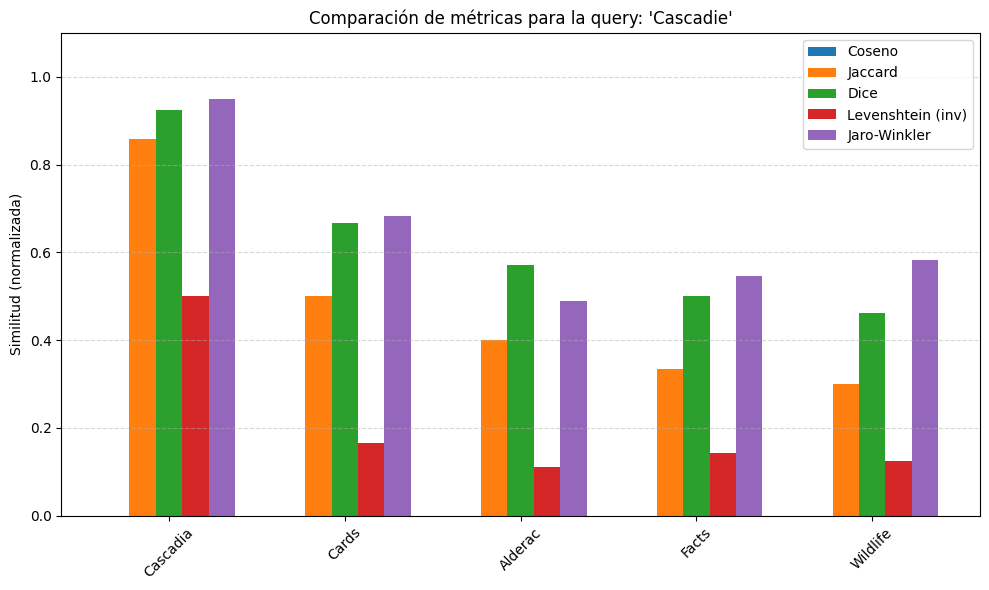

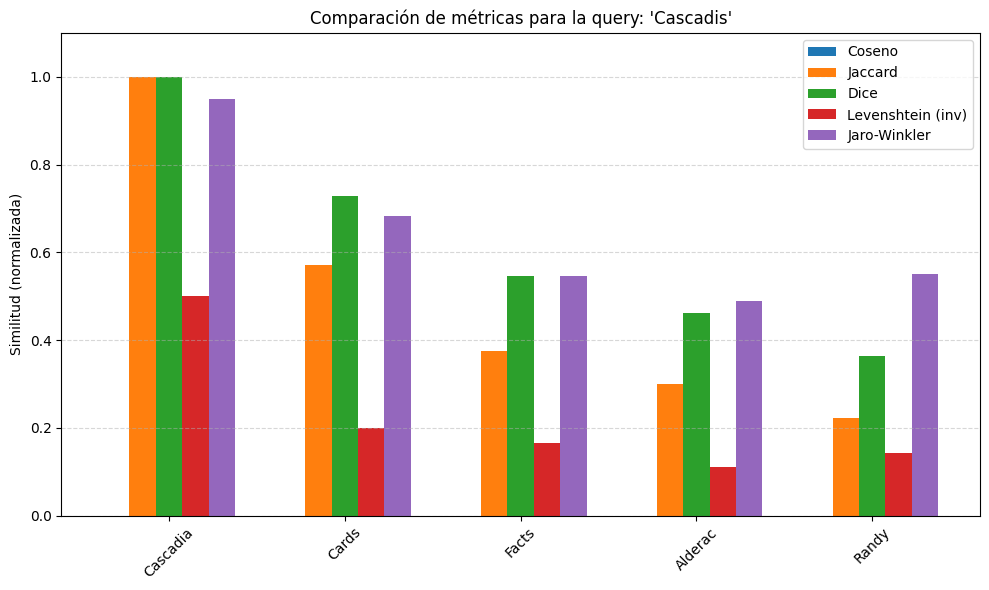

In [27]:
# GRAFICAR RESULTADOS
graficar_comparacion(top_cascadie, "Comparación de métricas para la query: 'Cascadie'")
graficar_comparacion(top_cascadis, "Comparación de métricas para la query: 'Cascadis'")

### Conclusión

Para probar qué tan bien funcionan las distintas métricas cuando hay errores de tipeo, comparé las palabras mal escritas **"Cascadie"** y **"Cascadis"** con la palabra correcta **"Cascadia"**, usando diferentes formas de medir similitud.

Lo primero que noté es que la **similitud del coseno** no sirvió en estos casos: dio valores muy bajos o directamente cero, porque necesita que las palabras coincidan exactamente, y no maneja bien errores ortográficos.

Las métricas **Jaccard** y **Dice** a veces dieron resultados altos, incluso perfectos (1.0), pero eso es porque comparan solo las letras que comparten, sin importar el orden. Por eso, aunque parezcan buenas, pueden dar resultados engañosos si las palabras tienen letras parecidas pero están desordenadas.

En cambio, **Levenshtein** y sobre todo **Jaro-Winkler** funcionaron mucho mejor. Estas métricas sí tienen en cuenta el orden de los caracteres y cuán parecidas son las palabras en forma general. Por ejemplo, Jaro-Winkler dio **0.95** de similitud entre "Cascadia" y "Cascadie", reconociendo que es solo una letra diferente.

Por todo esto, puedo decir que **Jaro-Winkler es la métrica más confiable** para este tipo de búsquedas, donde puede haber errores de escritura o variantes mínimas. Es la que mejor refleja la similitud real entre palabras parecidas.


# Ejercicio 4

Mediante detección de idioma, separar los archivos en distintos lenguajes y guardar esa
información en un dataframe.


Vamos a aplicar un proceso de detección de idioma sobre cada uno de los archivos utilizando la librería `langdetect`.

In [ ]:
!pip install langdetect

In [31]:
import os
import pandas as pd
from langdetect import detect_langs

# Ruta de la carpeta
folder_path = '/content/drive/MyDrive/NLP_CASCADIA_AD/datos/información'

# Función para leer el contenido de un archivo
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Lista para almacenar los resultados
results = []

# Recorrer los archivos de la carpeta
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    # Solo procesamos si es un archivo (no directorio)
    if os.path.isfile(file_path):
        try:
            # Leer el contenido del archivo
            text = read_file(file_path)

            # Detectar los idiomas
            idiomas = detect_langs(text)

            # Obtener el idioma con la mayor probabilidad
            idioma_principal = max(idiomas, key=lambda x: x.prob)

            # Agregar el nombre del archivo y el idioma principal al resultado
            results.append((filename, idioma_principal.lang, idioma_principal.prob))
        except Exception as e:
            print(f"No se pudo procesar el archivo {filename}. Error: {e}")

# Crear un DataFrame con los resultados
df = pd.DataFrame(results, columns=['Archivo', 'Idioma', 'Probabilidad'])

# Mostrar el DataFrame
df

No se pudo procesar el archivo oneboardfamily_review.docx. Error: 'utf-8' codec can't decode byte 0xbc in position 10: invalid start byte


,Archivo,Idioma,Probabilidad
0,cascadia_manual.txt,en,0.999997
1,whatboardgame_review.txt,en,0.999996
2,oneboardfamily_review.txt,en,0.999997
3,flatout_games.txt,en,0.999997
4,boardgamereview_review.txt,en,0.999997
5,board_game_co_uk_guide.txt,en,0.999997
6,bluehighwaygames_description.txt,en,0.999995
7,foro_reviews_cascadia.txt,en,0.999997


Esto nos devolvió que **todos los textos extraídos están en inglés**, con un alto porcentaje de probabilidad en todos los casos.

Al verificar manualmente el contenido de los archivos en la carpeta, pudimos confirmar que efectivamente **todo el material se encuentra en inglés**, lo que valida el resultado del análisis automático.

# Ejercicio 5

En el caso de las reseñas realizadas por usuarios, utiliza análisis de sentimientos con
modelos pre entrenados y guarda la clasificación predecida de cada reseña.

Luego, crea un sistema de búsquedas por similitud semántica y que permita filtrar por
sentimiento para obtener.


### Análisis de sentimiento

Instalamos e importamos las librerías necesarias para el análisis de sentimiento

In [ ]:
!pip install transformers
!pip install nltk

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import pandas as pd
from collections import Counter
import torch

# Descargar tokenizer de oraciones
nltk.download('punkt')

# Modelo y tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Este modelo devuelve una clasificación de 1 a 5 estrellas, que interpretamos de la siguiente manera:

- 1 o 2 → Negativo

- 3 → Neutral

- 4 o 5 → Positivo

In [ ]:
# Función para convertir estrellas a positivo/neutral/negativo
def interpretar_sentimiento(label):
    estrellas = int(label[0])
    if estrellas <= 2:
        return "negativo"
    elif estrellas == 3:
        return "neutral"
    else:
        return "positivo"

Dado que el modelo tiene una limitación de 512 tokens, dividimos las reseñas largas en fragmentos para poder analizarlas correctamente. Calculamos la etiqueta más común y el promedio de confianza del modelo.

In [ ]:
# Función para analizar reseñas largas
def analizar_reseña_larga(texto):
    oraciones = sent_tokenize(texto)
    labels = []
    scores = []
    for oracion in oraciones:
        tokens = tokenizer(oracion, truncation=True, max_length=512)
        if len(tokens["input_ids"]) <= 512:
            resultado = sentiment_analyzer(oracion)[0]
            labels.append(resultado["label"])
            scores.append(resultado["score"])
    if labels:
        label_mas_comun = Counter(labels).most_common(1)[0][0]
        score_promedio = sum(scores) / len(scores)
        return label_mas_comun, round(score_promedio, 3)
    else:
        return "Sin análisis", 0.0


Ahora cargamos el archivo con reseñas extraídas de la página BGG las cuales están separadas por '-----', analizamos cada una y guardamos los resultados.

In [ ]:
# Leer archivo con reseñas separadas por '-----'
ruta_archivo = "/content/drive/MyDrive/NLP_CASCADIA_AD/datos/información/foro_reviews_cascadia.txt"
with open(ruta_archivo, "r", encoding="utf-8") as f:
    bloques = f.read().split("-----")

# Analizar cada reseña
resultados = []

for bloque in bloques:
    lineas = bloque.strip().split("\n")
    if len(lineas) >= 2:
        titulo = lineas[0].strip()
        reseña = " ".join([linea.strip() for linea in lineas[1:] if linea.strip()])

        if reseña:
            label_crudo, score = analizar_reseña_larga(reseña)
            sentimiento = interpretar_sentimiento(label_crudo)

            resultados.append({
                "titulo": titulo,
                "reseña": reseña,
                "sentimiento": sentimiento,
                "valor_crudo": label_crudo,
                "score": score
            })

# Guardar como DF y mostrar los resultados
df = pd.DataFrame(resultados)
df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Device set to use cpu


,titulo,reseña,sentimiento,valor_crudo,score
0,Cascadia in 2025: It’s rare to find a game tha...,"When you sit down to play, you find a serene p...",positivo,4 stars,0.476
1,"Cascadia - The Official ""Rolling In The Meep"" ...",The Pacific Northwest is a beautiful place. We...,positivo,4 stars,0.458
2,Cascadia Review of Gameplay and Mechanics (Mos...,I recently played Cascadia (2021) in an enviro...,neutral,3 stars,0.501
3,Cascadia: The Perfect Mix of Strategy and Fun ...,One of the best things about Cascadia is its v...,positivo,5 stars,0.500
4,?Cascadia Review?: Cascadia Review,1-4 Players 30-45 Minutes Medium Light Weight ...,positivo,4 stars,0.493
5,"The Lure of Cascadia: It was there, in the elk...",The lure of Cascadia. I was captivated. It did...,positivo,5 stars,0.442
6,Introduce this to new board gamers: Story Time,"There is a store called Second & Charles, kind...",neutral,3 stars,0.451
7,Cascading Through My Heart: Hexagons Are Besta...,"I'm feeling a bit blue, to be honest. Game Nam...",positivo,4 stars,0.480
8,Cascadia Review (Rolls in the Family): Origina...,"Overview In Cascadia, you are building out you...",positivo,4 stars,0.481
9,Playing with a 5 year old: My son turned five ...,"I made one minor adjustment to the rules, whic...",positivo,4 stars,0.516


In [ ]:
# Guardar el df en el drive
df.to_csv("/content/drive/MyDrive/NLP_CASCADIA_AD/sentimientos_reviews.csv", index=False)

### Recomendación

Se construyó un sistema de búsqueda que permite encontrar reseñas similares a una frase dada (query), filtrando opcionalmente por sentimiento (positivo, neutral, o negativo).
El sistema utiliza embeddings multilingües y calcula la similitud semántica utilizando coseno.

Carga del modelo de embeddings

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Cargar un modelo multilingüe
modelo_embeddings = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Crear embeddings de las reseñas
df["embedding"] = df["reseña"].apply(lambda x: modelo_embeddings.encode(x, convert_to_tensor=True))

Función de búsqueda

In [ ]:
def buscar_reseñas(query="", sentimiento=None, top_k=3):
    # Vectorizamos la query
    query_embedding = modelo_embeddings.encode(query, convert_to_tensor=True)

    # Si hay filtro por sentimiento, aplicarlo
    if sentimiento:
        df_filtrado = df[df["sentimiento"] == sentimiento.lower()]
    else:
        df_filtrado = df

    if df_filtrado.empty:
        print("No hay reseñas con ese sentimiento.")
        return []

    # Calcular similitud coseno
    embeddings = torch.stack(list(df_filtrado["embedding"].values))
    similitudes = util.cos_sim(query_embedding, embeddings).squeeze().tolist()

    # Agregar similitud al DataFrame
    df_filtrado = df_filtrado.copy()
    df_filtrado["similitud"] = similitudes

    # Ordenar por similitud
    resultados = df_filtrado.sort_values(by="similitud", ascending=False).head(top_k)

    return resultados[["titulo", "reseña", "sentimiento", "similitud"]]

Ejemplos de búsqueda

In [ ]:
# Buscar por reseña y con filtro de sentimiento
print(buscar_reseñas("fun game for the family", sentimiento='neutral'))

# Buscar solo por sentimiento
print(buscar_reseñas(sentimiento='neutral'))

# Buscar solo por reseña
print(buscar_reseñas("great game"))

                                               titulo  \
17  Cascadia: een gedroomd debuut!, door Bordspelw...   
16  Cascadia, by Bordspelwereld [EN]: The fact tha...   
13  Gaming with children aged 14 to 16 - Cascadia:...   

                                               reseña sentimiento  similitud  
17  Voor mij de tweede keer, voor hen de eerste. L...     neutral   0.340435  
16  The second time for me, the first for them. Re...     neutral   0.330190  
13  Fun Components: I wouldn't say the components ...     neutral   0.306718  
                                               titulo  \
6      Introduce this to new board gamers: Story Time   
17  Cascadia: een gedroomd debuut!, door Bordspelw...   
37      Sopophoria (a Space-Biff! review): Sopophoria   

                                               reseña sentimiento  similitud  
6   There is a store called Second & Charles, kind...     neutral   0.006244  
17  Voor mij de tweede keer, voor hen de eerste. L...     neutral   

Al analizar las reseñas con el modelo de sentimiento, todas dieron como resultado positivo o neutral, no apareció ninguna negativa. Esto nos da una idea bastante clara: la mayoría de las personas están conformes con el juego Cascadia y no hay críticas fuertes registradas en las reseñas analizadas.

En cuanto al sistema de búsqueda por similitud semántica, si bien los valores de similitud no fueron muy altos (el más alto fue 0.37), los resultados que devuelve son tienen sentido con respecto a la frase ingresada. Esto demuestra que, incluso con valores bajos, el modelo logra encontrar reseñas relacionadas de manera coherente, lo que lo hace útil como sistema de recomendación.

# Ejercicio 6

Crea un set de datos de consultas (más de 300 preguntas en total) y categorizalas entre la fuente de datos que pueda llegar a responder esa pregunta entre estadísticas, información y relaciones.

Por ejemplo:
- ¿Cómo gano en el ajedrez? -> **Información**  
- ¿Quién trabajó para el ta-te-ti? -> **Relaciones**
- ¿Qué puntaje tienen las damas? -> **Estadística**

A continuación, transforma esas consultas en vectores y entrena un modelo de clasificación (a gusto del estudiante) en donde pueda predecir la categoría a través de la consulta ingresada.

Agregar métricas y análisis durante todo el desarrollo, trabaje en varios modelos y comparelos.

### Definición del dataset y sus etiquetas

En este ejercicio se busca entrenar un modelo que permita clasificar preguntas relacionadas al juego Cascadia en una de tres categorías:

- **Información:** datos directos o definiciones sobre el juego.

- **Relaciones:** vínculos entre elementos del juego.

- **Estadísticas:** análisis cuantitativos o métricas.


In [ ]:
# Definimos las etiquetas
labels = [(0, "Información"),(1, "Relaciones"), (2, "Estadísticas")]
dataset = []

# Informacion
dataset.extend([
    (0, 'How many players can participate in Cascadia?'),
    (0, 'What is the main objective of Cascadia?'),
    (0, 'What types of habitats are featured in Cascadia?'),
    (0, 'Which animals are included in the game?'),
    (0, 'What components come in the Cascadia box?'),
    (0, 'What does a nature token do in the game?'),
    (0, 'What is the setup process for a standard game?'),
    (0, 'How does scoring work for habitat corridors?'),
    (0, 'What is the purpose of wildlife scoring cards?'),
    (0, 'What happens when a player cannot place a tile?'),
    (0, 'What is the role of keystone habitats?'),
    (0, 'How many wildlife scoring cards are used per game?'),
    (0, 'What triggers the end of the game?'),
    (0, 'Can a tile be placed without an animal token?'),
    (0, 'What is a habitat corridor?'),
    (0, 'How do you score a bear pattern?'),
    (0, 'What is the effect of the salmon run scoring card?'),
    (0, 'Are all animals scored in the same way?'),
    (0, 'How is the winner determined in Cascadia?'),
    (0, 'What are achievement tiles used for?'),
    (0, 'What’s the difference between beginner and advanced wildlife scoring cards?'),
    (0, 'What is the family variant in Cascadia?'),
    (0, 'How do you use the nature tokens in a turn?'),
    (0, 'Can two animals of the same type be placed next to each other?'),
    (0, 'What happens when the wildlife token supply runs out?'),
    (0, 'Is there a solo mode in Cascadia?'),
    (0, 'What is a keystone tile?'),
    (0, 'How is a fox scored in the base game?'),
    (0, 'What is the expansion “Landmarks” about?'),
    (0, 'What changes in gameplay does the expansion introduce?'),
    (0, 'How is habitat corridors scored in Cascadia?'),
    (0, 'How does the game handle habitat corridors?'),
    (0, 'What are the rules for nature token use?'),
    (0, 'What strategy helps with wildlife selection?'),
    (0, 'How is achievement goals scored in Cascadia?'),
    (0, 'What happens if habitat corridors occurs?'),
    (0, 'How is nature token use scored in Cascadia?'),
    (0, 'What happens if token swapping occurs?'),
    (0, 'What are the rules for scoring salmon?'),
    (0, 'How does the game handle tile drafting?'),
    (0, 'What strategy helps with nature token use?'),
    (0, 'How does the game handle achievement goals?'),
    (0, 'How does the game handle token swapping?'),
    (0, 'What are the rules for wildlife selection?'),
    (0, 'What happens if scoring salmon occurs?'),
    (0, 'What happens if tile drafting occurs?'),
    (0, 'How does the game handle scoring salmon?'),
    (0, 'How is scoring salmon scored in Cascadia?'),
    (0, 'What happens if wildlife selection occurs?'),
    (0, 'How is wildlife selection scored in Cascadia?'),
    (0, 'What happens if turn order occurs?'),
    (0, 'How is keystone tile placement scored in Cascadia?'),
    (0, 'How is turn order scored in Cascadia?'),
    (0, 'What happens if achievement goals occurs?'),
    (0, 'What strategy helps with scoring salmon?'),
    (0, 'What are the rules for achievement goals?'),
    (0, 'What strategy helps with turn order?'),
    (0, 'What strategy helps with placing bear patterns?'),
    (0, 'What strategy helps with keystone tile placement?'),
    (0, 'What happens if nature token use occurs?'),
    (0, 'How does the game handle keystone tile placement?'),
    (0, 'What strategy helps with habitat corridors?'),
    (0, 'What are the rules for token swapping?'),
    (0, 'How does the game handle wildlife selection?'),
    (0, 'What happens if placing bear patterns occurs?'),
    (0, 'How is placing bear patterns scored in Cascadia?'),
    (0, 'How does the game handle nature token use?'),
    (0, 'What strategy helps with tile drafting?'),
    (0, 'What are the rules for placing bear patterns?'),
    (0, 'How does the game handle placing bear patterns?'),
    (0, 'What strategy helps with token swapping?'),
    (0, 'What are the rules for keystone tile placement?'),
    (0, 'What are the rules for tile drafting?'),
    (0, 'How is token swapping scored in Cascadia?'),
    (0, 'How does the game handle turn order?'),
    (0, 'How is tile drafting scored in Cascadia?'),
    (0, 'What are the rules for habitat corridors?'),
    (0, 'What are the rules for turn order?'),
    (0, 'What strategy helps with achievement goals?'),
    (0, 'What happens if keystone tile placement occurs?')
])

# Relaciones
dataset.extend([
    (1, 'Which animals can live in river habitats?'),
    (1, 'What animal types share the same habitat in the game?'),
    (1, 'Which animal scoring cards relate to adjacent tiles?'),
    (1, 'What tiles can be connected to forest terrain?'),
    (1, 'Which animals are connected to the keystone tiles?'),
    (1, 'What animals are most often adjacent in the same tile?'),
    (1, 'Which habitats can connect to both mountain and wetlands?'),
    (1, 'What tile types share a terrain and an animal?'),
    (1, 'Which animals have scoring rules that depend on other animals?'),
    (1, 'Which two terrain types appear most frequently together?'),
    (1, 'Are there tiles with both fox and forest?'),
    (1, 'What animal pairs score higher together?'),
    (1, 'Which habitats allow the placement of salmon?'),
    (1, 'Which animal scoring cards depend on grouping of other animals?'),
    (1, 'What terrain is connected to elk migration routes?'),
    (1, 'Are there tiles that support more than one habitat?'),
    (1, 'What types of scoring patterns involve adjacency?'),
    (1, 'What habitats connect to wetland and forest?'),
    (1, 'Which animal types influence fox scoring?'),
    (1, 'Which tokens are connected to multiple animals?'),
    (1, 'What animal groups cluster around mountains?'),
    (1, 'What terrain types support both hawks and bears?'),
    (1, 'Which scoring card links foxes and their neighbors?'),
    (1, 'Which two animals rarely appear together in the same tile?'),
    (1, 'Which tile types are most versatile in placement?'),
    (1, 'Which animals are typically found near adjacent animals?'),
    (1, 'What habitats connect with scoring synergies in Cascadia?'),
    (1, 'Which scoring cards involve scoring synergies relations?'),
    (1, 'What terrain types are related to forests?'),
    (1, 'What habitats connect with tiles with dual habitats in Cascadia?'),
    (1, 'What tiles commonly feature both rivers and animals?'),
    (1, 'What habitats connect with elk in Cascadia?'),
    (1, 'Which scoring cards involve tiles with dual habitats relations?'),
    (1, 'What habitats connect with hawks in Cascadia?'),
    (1, 'What tiles commonly feature both adjacent animals and animals?'),
    (1, 'Which animals are typically found near tiles with dual habitats?'),
    (1, 'Which animals are typically found near rivers?'),
    (1, 'Which animals are typically found near forests?'),
    (1, 'What tiles commonly feature both forests and animals?'),
    (1, 'What terrain types are related to rivers?'),
    (1, 'What terrain types are related to mountains?'),
    (1, 'Which animals are typically found near scoring synergies?'),
    (1, 'What habitats connect with rivers in Cascadia?'),
    (1, 'What terrain types are related to scoring synergies?'),
    (1, 'What habitats connect with foxes in Cascadia?'),
    (1, 'What terrain types are related to wetlands?'),
    (1, 'What terrain types are related to hawks?'),
    (1, 'Which animals are typically found near mountains?'),
    (1, 'Which animals are typically found near elk?'),
    (1, 'Which scoring cards involve mountains relations?'),
    (1, 'What terrain types are related to elk?'),
    (1, 'Which scoring cards involve hawks relations?'),
    (1, 'Which scoring cards involve foxes relations?'),
    (1, 'What tiles commonly feature both scoring synergies and animals?'),
    (1, 'What tiles commonly feature both foxes and animals?'),
    (1, 'Which scoring cards involve wetlands relations?'),
    (1, 'What habitats connect with adjacent animals in Cascadia?'),
    (1, 'Which scoring cards involve forests relations?'),
    (1, 'Which scoring cards involve elk relations?'),
    (1, 'Which animals are typically found near wetlands?'),
    (1, 'What tiles commonly feature both tiles with dual habitats and animals?'),
    (1, 'What terrain types are related to adjacent animals?'),
    (1, 'What habitats connect with mountains in Cascadia?'),
    (1, 'Which scoring cards involve adjacent animals relations?'),
    (1, 'What terrain types are related to tiles with dual habitats?'),
    (1, 'Which animals are typically found near foxes?'),
    (1, 'What tiles commonly feature both elk and animals?'),
    (1, 'What tiles commonly feature both wetlands and animals?'),
    (1, 'Which animals are typically found near hawks?'),
    (1, 'What terrain types are related to foxes?'),
    (1, 'What habitats connect with wetlands in Cascadia?'),
    (1, 'What habitats connect with forests in Cascadia?'),
    (1, 'Which scoring cards involve rivers relations?'),
    (1, 'What tiles commonly feature both hawks and animals?'),
    (1, 'What tiles commonly feature both mountains and animals?')
])

# Estadísticas
dataset.extend([
    (2, 'What is the average score of a winning player?'),
    (2, 'How many habitat types are there in total?'),
    (2, 'What is the most frequent terrain type?'),
    (2, 'What is the highest recorded fox score?'),
    (2, 'What percentage of tiles support wetlands?'),
    (2, 'What’s the standard deviation of game duration?'),
    (2, 'How many nature tokens are distributed per game on average?'),
    (2, 'How often do salmon score more than 10 points?'),
    (2, 'What is the most common animal among all tiles?'),
    (2, 'How many scoring cards exist in the base game?'),
    (2, 'What is the average number of keystone tiles per player?'),
    (2, 'What is the median final score across all players?'),
    (2, 'How many times has the bear pattern B2 been selected?'),
    (2, 'What percentage of players use the fox scoring card C3?'),
    (2, 'How frequently do players use nature tokens?'),
    (2, 'What’s the maximum score achievable with elk?'),
    (2, 'What is the average number of tiles placed per player?'),
    (2, 'What is the win rate when choosing the hawk scoring card A1?'),
    (2, 'How many games end with less than 5 unused tiles?'),
    (2, 'What is the frequency of tie games?'),
    (2, 'What is the average habitat corridor length?'),
    (2, 'What is the typical count of adjacent similar terrain tiles?'),
    (2, 'What is the average point contribution from salmon scoring?'),
    (2, 'What is the highest number of tokens held by one player at once?'),
    (2, 'What’s the percentage of fox tokens used successfully in scoring?'),
    (2, 'What percentage of players achieve nature tokens used?'),
    (2, 'How many achievement completions appear per session?'),
    (2, 'What is the average value of fox efficiency per game?'),
    (2, 'How often does keystone placements exceed 50% in Cascadia?'),
    (2, 'What percentage of players achieve wildlife token draws?'),
    (2, 'How many bear scoring appear per session?'),
    (2, 'What is the average value of achievement completions per game?'),
    (2, 'How many salmon points appear per session?'),
    (2, 'What is the average value of wildlife token draws per game?'),
    (2, 'What is the typical count of final score in the final score?'),
    (2, 'What percentage of players achieve number of tiles?'),
    (2, 'What is the average value of keystone placements per game?'),
    (2, 'How many keystone placements appear per session?'),
    (2, 'What is the typical count of wildlife token draws in the final score?'),
    (2, 'What is the typical count of keystone placements in the final score?'),
    (2, 'What percentage of players achieve final score?'),
    (2, 'How many games with tie appear per session?'),
    (2, 'How often does nature tokens used exceed 10 in Cascadia?'),
    (2, 'What percentage of players achieve achievement completions?'),
    (2, 'How often does achievement completions exceed 5 in Cascadia?'),
    (2, 'What percentage of players achieve games with tie?'),
    (2, 'What is the average value of salmon points per game?'),
    (2, 'What percentage of players achieve bear scoring?'),
    (2, 'What percentage of players achieve salmon points?'),
    (2, 'What is the average value of number of tiles per game?'),
    (2, 'How many wildlife token draws appear per session?'),
    (2, 'How often does number of tiles exceed 100 in Cascadia?'),
    (2, 'What is the typical count of salmon points in the final score?'),
    (2, 'What is the typical count of fox efficiency in the final score?'),
    (2, 'What is the typical count of games with tie in the final score?'),
    (2, 'How often does number of tiles exceed 75% in Cascadia?'),
    (2, 'What percentage of players achieve fox efficiency?'),
    (2, 'How often does nature tokens used exceed 5 in Cascadia?'),
    (2, 'How many nature tokens used appear per session?'),
    (2, 'What is the average value of bear scoring per game?'),
    (2, 'How many number of tiles appear per session?'),
    (2, 'How many fox efficiency appear per session?'),
    (2, 'What is the typical count of number of tiles in the final score?'),
    (2, 'How often does bear scoring exceed 20 in Cascadia?'),
    (2, 'How often does games with tie exceed 20 in Cascadia?'),
    (2, 'What is the average value of games with tie per game?'),
    (2, 'How often does bear scoring exceed 10 in Cascadia?'),
    (2, 'How often does games with tie exceed 75% in Cascadia?'),
    (2, 'How often does fox efficiency exceed 10 in Cascadia?'),
    (2, 'How often does fox efficiency exceed 20 in Cascadia?'),
    (2, 'How often does salmon points exceed 5 in Cascadia?'),
    (2, 'How often does number of tiles exceed 5 in Cascadia?'),
    (2, 'How often does keystone placements exceed 5 in Cascadia?'),
    (2, 'How often does nature tokens used exceed 100 in Cascadia?'),
    (2, 'How often does salmon points exceed 50% in Cascadia?'),
    (2, 'How often does wildlife token draws exceed 50% in Cascadia?'),
    (2, 'What is the typical count of nature tokens used in the final score?'),
    (2, 'How often does games with tie exceed 100 in Cascadia?'),
    (2, 'How often does salmon points exceed 100 in Cascadia?'),
    (2, 'What is the typical count of bear scoring in the final score?'),
    (2, 'What is the typical count of achievement completions in the final score?'),
    (2, 'What is the average value of final score per game?'),
    (2, 'What percentage of players achieve keystone placements?'),
    (2, 'What is the average value of nature tokens used per game?'),
    (2, 'How often does wildlife token draws exceed 75% in Cascadia?'),
    (2, 'How often does nature tokens used exceed 75% in Cascadia?'),
    (2, 'How often does wildlife token draws exceed 5 in Cascadia?'),
    (2, 'How often does keystone placements exceed 20 in Cascadia?'),
    (2, 'How often does number of tiles exceed 50% in Cascadia?'),
    (2, 'How often does salmon points exceed 10 in Cascadia?'),
    (2, 'How often does nature tokens used exceed 20 in Cascadia?'),
    (2, 'How many final score appear per session?'),
    (2, 'How often does bear scoring exceed 5 in Cascadia?'),
    (2, 'How often does achievement completions exceed 10 in Cascadia?'),
    (2, 'How often does games with tie exceed 10 in Cascadia?'),
    (2, 'How often does final score exceed 10 in Cascadia?'),
    (2, 'How often does final score exceed 5 in Cascadia?'),
    (2, 'How often does final score exceed 100 in Cascadia?'),
    (2, 'How often does bear scoring exceed 100 in Cascadia?'),
    (2, 'How often does number of tiles exceed 10 in Cascadia?')
])

In [ ]:
!pip install sentence-transformers gensim scikit-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import gensim.downloader as api

#### Carga de datos y Separación en entrenamiento y prueba

In [ ]:
# Cargar de datos
df = pd.DataFrame(dataset, columns=["categoria", "pregunta"])

etiquetas = {0: "Información", 1: "Relaciones", 2: "Estadísticas"}
df["etiqueta"] = df["categoria"].map(etiquetas)

X_text = df["pregunta"].values
y = df["categoria"].values

# División del dataset (80% train, 20% test)
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, stratify=y, random_state=42)


#### Definición de mdelos y vectorizadores a evaluar

In [ ]:
# Definir clasificadores
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

# === TF-IDF ===
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# === FastText ===
ft_model = api.load("fasttext-wiki-news-subwords-300")

def fasttext_embed(texts):
    embeddings = []
    for text in texts:
        words = text.split()
        vectors = [ft_model[w] for w in words if w in ft_model]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(300))
    return np.array(embeddings)

X_train_ft = fasttext_embed(X_train_text)
X_test_ft = fasttext_embed(X_test_text)

# === SBERT ===
sbert = SentenceTransformer("all-MiniLM-L6-v2")
X_train_sbert = sbert.encode(X_train_text, show_progress_bar=True)
X_test_sbert = sbert.encode(X_test_text, show_progress_bar=True)

#### Comparación de modelos y vectorizadores

In [ ]:
# === Evaluar ===
def evaluate_models(X_train, X_test, y_train, y_test, vectorizer_name):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        results.append({
            "Vectorizer": vectorizer_name,
            "Model": name,
            "Accuracy": accuracy_score(y_test, preds),
            "F1_macro": classification_report(y_test, preds, output_dict=True)["macro avg"]["f1-score"]
        })
    return results

results = []
results += evaluate_models(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF")
results += evaluate_models(X_train_ft, X_test_ft, y_train, y_test, "FastText")
results += evaluate_models(X_train_sbert, X_test_sbert, y_train, y_test, "SBERT")

# === 8. Mostrar resultados ===
results_df = pd.DataFrame(results)
results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

[==================================================] 100.0% 958.5/958.4MB downloaded


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

,Vectorizer,Model,Accuracy,F1_macro
0,FastText,RandomForest,0.941176,0.939683
1,SBERT,LogisticRegression,0.901961,0.900354
2,SBERT,RandomForest,0.901961,0.900354
3,TF-IDF,LogisticRegression,0.882353,0.880846
4,TF-IDF,RandomForest,0.862745,0.861862
5,TF-IDF,KNN,0.862745,0.858406
6,FastText,LogisticRegression,0.862745,0.860091
7,FastText,KNN,0.862745,0.853782
8,SBERT,KNN,0.823529,0.810270


Luego de evaluar diferentes combinaciones de vectorizadores y clasificadores sobre un conjunto balanceado de 300 preguntas (100 por categoría: información, relaciones y estadísticas), se observó que la combinación de FastText como vectorizador y Random Forest como clasificador obtuvo el mejor desempeño global.

Con un accuracy de 94.1%, esta combinación demostró ser la más efectiva para capturar tanto la semántica de las preguntas como las relaciones internas entre sus componentes. FastText, al trabajar con sub-palabras y preservar información morfológica, permite representar adecuadamente preguntas variadas. Por su parte, Random Forest aporta robustez ante posibles outliers y permite manejar bien los límites entre clases.

Este resultado sugiere que, para este tipo de tarea de clasificación semántica basada en preguntas cortas con vocabulario especializado (como ocurre en juegos de mesa), los embeddings de FastText combinados con un clasificador ensemble no lineal como Random Forest ofrecen una solución muy sólida, superando incluso a modelos modernos como Sentence-BERT en este contexto específico.

### Validación del modelo con preguntas nuevas

Para probar la capacidad de generalización del modelo entrenado, se reutiliza la combinación que obtuvo el mejor desempeño: FastText + Random Forest. Se entrena con todo el dataset original y se lo pone a prueba con nuevas preguntas no vistas anteriormente.

In [ ]:
# Reutilizamos el modelo de FastText (ya cargado previamente)
X_all_text = df["pregunta"].values
y_all = df["categoria"].values

X_all_ft = fasttext_embed(X_all_text)

# Entrenar el modelo definitivo
from sklearn.ensemble import RandomForestClassifier

final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_all_ft, y_all)

RandomForestClassifier(random_state=42)

#### Predicción sobre preguntas nuevas

In [ ]:
nuevas_preguntas = [
    "How many types of terrain are there in the game?",       # Información
    "Which animals are usually placed near rivers?",          # Relaciones
    "What is the average final score per player?",            # Estadísticas
    "How do you use a keystone tile?",                        # Información
    "Which terrain types connect most often with foxes?",     # Relaciones
    "What’s the most common scoring combination in Cascadia?" # Estadísticas
]

In [ ]:
# Vectorizar con FastText
nuevas_vec = fasttext_embed(nuevas_preguntas)

# Predecir
predicciones = final_model.predict(nuevas_vec)

# Mapear resultados
etiquetas = {0: "Información", 1: "Relaciones", 2: "Estadísticas"}
for pregunta, pred in zip(nuevas_preguntas, predicciones):
    print(f"{pregunta} => {etiquetas[pred]}")

How many types of terrain are there in the game? => Estadísticas
Which animals are usually placed near rivers? => Relaciones
What is the average final score per player? => Estadísticas
How do you use a keystone tile? => Información
Which terrain types connect most often with foxes? => Relaciones
What’s the most common scoring combination in Cascadia? => Estadísticas


Para evaluar la capacidad de generalización del modelo FastText + Random Forest más allá del dataset original, se probaron seis preguntas nuevas no presentes en el entrenamiento. De las seis preguntas, cinco fueron clasificadas correctamente, lo cual representa un acierto del 83.3% en esta muestra externa.

El único error se dio en una pregunta que comenzaba con “How many...”, lo cual probablemente indujo al modelo a etiquetarla como estadística, cuando en realidad se trataba de una pregunta informativa sobre el reglamento del juego. Este caso sugiere que, si bien el modelo captura correctamente patrones semánticos generales, puede verse influenciado por palabras clave si el contexto no es lo suficientemente claro.

En general, los resultados muestran que el modelo logra diferenciar correctamente entre preguntas de tipo informativo, relacional y estadístico incluso en ejemplos nuevos, validando su utilidad práctica como sistema de clasificación semántica para preguntas sobre el juego Cascadia.